### This script shows a basic example of training a SentenceTransformer multimodal model with omics data stored in anndata format

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from mmcontext.utils import setup_logging

setup_logging()

mmcontext.utils - INFO - mmcontext logging configured using the specified configuration file.


In [11]:
omics_model_cfg = {
    "embedding_dim": 50,
    "hidden_dim": 128,
    "num_layers": 1,
    "num_heads": 0,
    "use_self_attention": False,
    "activation": "relu",
    "dropout": 0.1,
}

In [12]:
from mmcontext.models import MMContextEncoder

model = MMContextEncoder(
    text_encoder_name="sentence-transformers/all-MiniLM-L6-v2",
    processor_obsm_key="X_pp",
    omics_encoder_cfg=omics_model_cfg,
)

In [55]:
from sentence_transformers import SentenceTransformer

modules = [model]
bimodal_model = SentenceTransformer(modules=modules)

sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps


In [56]:
bimodal_model.save("../../data/models/mmcontext_model")

sentence_transformers.SentenceTransformer - INFO - Save model to ../../data/models/mmcontext_model


In [57]:
model = SentenceTransformer("../../data/models/mmcontext_model")

sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: ../../data/models/mmcontext_model


In [13]:
import anndata
import scanpy as sc

from mmcontext.pp import consolidate_low_frequency_categories

# train_path = "../../data/scib_data/split_random/train/Lung_atlas_public.zarr"
train_path = "../../data/raw/large_cellxgene.h5ad"
# Include a representation in X_pp. We use raw data for noe
# adata = anndata.read_zarr(train_path)
adata = anndata.read_h5ad(train_path)
adata = consolidate_low_frequency_categories(adata, ["cell_type"], threshold=5)
# Of course there are better methods than just getting the first 512 genes. But the amount of features has to match the model dimensions
# use pca to get 512 dimensional embedding
adata

AnnData object with n_obs × n_vars = 5000 × 5000
    obs: 'soma_joinid', 'donor_id', 'disease', 'sex', 'dataset_id', 'cell_type', 'assay', 'tissue', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'caption'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'X_pp', 'scvi'

In [10]:
adata.obs["dataset_id"]

7       774c18c5-efa1-4dc5-9e5e-2c824bab2e34
11      774c18c5-efa1-4dc5-9e5e-2c824bab2e34
17      774c18c5-efa1-4dc5-9e5e-2c824bab2e34
21      774c18c5-efa1-4dc5-9e5e-2c824bab2e34
37      774c18c5-efa1-4dc5-9e5e-2c824bab2e34
                        ...                 
5583    9f222629-9e39-47d0-b83f-e08d610c7479
5587    9f222629-9e39-47d0-b83f-e08d610c7479
5593    9f222629-9e39-47d0-b83f-e08d610c7479
5595    9f222629-9e39-47d0-b83f-e08d610c7479
5599    9f222629-9e39-47d0-b83f-e08d610c7479
Name: dataset_id, Length: 1000, dtype: category
Categories (46, object): ['01209dce-3575-4bed-b1df-129f57fbc031', '0f4865d5-8000-4f68-8ac7-f5efea9e5e70', '1a2e3350-28a8-4f49-b33c-5b67ceb001f6', '1a38e762-2465-418f-b81c-6a4bce261c34', ..., 'e84f2780-51e8-4cfa-8aa0-13bbfef677c7', 'f801b7a9-80a6-4d09-9161-71474deb58ae', 'fd072bc3-2dfb-46f8-b4e3-467cb3223182', 'fe4b89d5-461e-440c-a5a8-621b37b122c0']

In [59]:
# if "X_pca" not in adata.obsm:
# sc.pp.pca(adata, n_comps=omics_model_cfg["embedding_dim"])
adata.obsm["X_pp"] = adata.obsm["scvi"]
adata.write_h5ad(train_path)

In [60]:
# train_path = train_path.replace(".zarr", ".h5ad")
# adata.write_h5ad(train_path)

In [61]:
from mmcontext.pp import AnnDataSetConstructor
from mmcontext.pp.caption_constructors import SimpleCaptionConstructor

# Create caption constructor with desired obs keys
caption_constructor = SimpleCaptionConstructor(obs_keys=["cell_type"])
constructor = AnnDataSetConstructor(caption_constructor=caption_constructor)
constructor.add_anndata(file_path=train_path)
# Get dataset
dataset = constructor.get_dataset()

mmcontext.pp.AnnDataDataSetConstructor - INFO - Successfully added anndata file: ../../data/raw/large_cellxgene.h5ad


... storing 'caption' as categorical


mmcontext.pp.AnnDataDataSetConstructor - INFO - Created 560000 examples for Hugging Face dataset.


In [62]:
# test_path = "../../data/scib_data/split_random/test/Lung_atlas_public.zarr"
test_path = "../../data/demo/small_cellxgene.zarr"
# Include a representation in X_pp. We use pca for now
adata = anndata.read_zarr(test_path)
adata = consolidate_low_frequency_categories(adata, ["cell_type"], threshold=5)
# if "X_pca" not in adata.obsm:
sc.pp.pca(adata, n_comps=omics_model_cfg["embedding_dim"])
adata.obsm["X_pp"] = adata.obsm["scvi"]
adata.write_zarr(test_path)
constructor.clear()
constructor.add_anndata(file_path=test_path)
# Get dataset
eval_dataset = constructor.get_dataset()

mmcontext.pp.AnnDataDataSetConstructor - INFO - Successfully added anndata file: ../../data/demo/small_cellxgene.zarr


... storing 'caption' as categorical


mmcontext.pp.AnnDataDataSetConstructor - INFO - Created 11200 examples for Hugging Face dataset.


In [15]:
# We'll create a DataLoader that batches our data and prepare a contrastive loss function
# from sentence_transformers import losses
# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(dataset, shuffle=True, batch_size=64)
# train_loss = losses.ContrastiveLoss(model=model)

# test_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

In [63]:
from datasets import load_dataset
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerModelCardData,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from sentence_transformers.evaluation import BinaryClassificationEvaluator
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers

# 3. Load a dataset to finetune on
train_dataset = dataset
eval_dataset = eval_dataset
test_dataset = eval_dataset

# 4. Define a loss function
loss = losses.ContrastiveLoss(model=model)

# 5. (Optional) Specify training arguments
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="../../data/models/mmcontext_trained",
    # Optional training parameters:
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    # batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name="mmcontext",  # Will be used in W&B if `wandb` is installed
)

# 6. (Optional) Create an evaluator & evaluate the base model
dev_evaluator = BinaryClassificationEvaluator(
    sentences1=eval_dataset["anndata_ref"],
    sentences2=eval_dataset["caption"],
    labels=eval_dataset["label"],
)
dev_evaluator(model)

# 7. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=dev_evaluator,
)
trainer.train()

## (Optional) Evaluate the trained model on the test set
# test_evaluator = TripletEvaluator(
#    anchors=test_dataset["anchor"],
#    positives=test_dataset["positive"],
#    negatives=test_dataset["negative"],
#    name="all-nli-test",
# )
# test_evaluator(model)

## 8. Save the trained model
# model.save_pretrained("models/mpnet-base-all-nli-triplet/final")

# 9. (Optional) Push it to the Hugging Face Hub
# model.push_to_hub("mpnet-base-all-nli-triplet")

sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset:
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             50.10	(Threshold: -0.2552)
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.3403)
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.03
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.98
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    41.87
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Matthews Correlation with Cosine-Similarity: 2.01



Step,Training Loss,Validation Loss,Cosine Accuracy,Cosine Accuracy Threshold,Cosine F1,Cosine F1 Threshold,Cosine Precision,Cosine Recall,Cosine Ap,Cosine Mcc
100,0.269000,0.256839,0.500446,-0.296202,0.666786,-0.352196,0.500134,1.000000,0.429974,0.016369
200,0.236900,0.223879,0.515893,-0.002073,0.666865,-0.279345,0.500223,1.000000,0.476278,0.021134
300,0.204200,0.182587,0.558750,0.122685,0.667863,-0.138106,0.502068,0.997143,0.576148,0.049388
400,0.175100,0.149779,0.615714,0.246663,0.674932,0.030190,0.524040,0.947857,0.670153,0.147860
500,0.145500,0.124803,0.674732,0.250268,0.703631,0.140967,0.593762,0.863393,0.749645,0.306055
600,0.121700,0.101131,0.738750,0.298830,0.749300,0.204740,0.678494,0.836607,0.823493,0.452641
700,0.098900,0.083867,0.768750,0.296443,0.780028,0.236882,0.716142,0.856429,0.856189,0.527178
800,0.090300,0.069985,0.807143,0.340900,0.811305,0.278001,0.764864,0.863750,0.887147,0.603277
900,0.073400,0.061426,0.823929,0.356227,0.826328,0.313819,0.790667,0.865357,0.901372,0.639108
1000,0.068600,0.054488,0.838839,0.363729,0.843170,0.319157,0.798722,0.892857,0.914123,0.672544


sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.002857142857142857 after 100 steps:
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             50.04	(Threshold: -0.2962)
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.68	(Threshold: -0.3522)
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.01
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               100.00
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    43.00
sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Matthews Correlation with Cosine-Similarity: 1.64

sentence_transformers.trainer - INFO - Savin

TrainOutput(global_step=35000, training_loss=0.015220996611458915, metrics={'train_runtime': 9830.1167, 'train_samples_per_second': 56.968, 'train_steps_per_second': 3.56, 'total_flos': 0.0, 'train_loss': 0.015220996611458915, 'epoch': 1.0})

In [64]:
model[0].processor.omics_processor.clear_cache()

In [65]:
model.save("../../data/models/trained_mmcontext_model_large_cellxgene")

sentence_transformers.SentenceTransformer - INFO - Save model to ../../data/models/trained_mmcontext_model_large_cellxgene


In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("../../data/models/trained_mmcontext_model_large_cellxgene")

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/numpyro/ops/provenance.py:99: DeprecationWarning: jax.core.call_p is deprecated. Use jax.extend.core.primitives.call_p
  track_deps_rules[core.call_p] = track_deps_call_rule
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/numpyro/ops/provenance.py:107: DeprecationWarning: jax.core.closed_call_p is deprecated. Use jax.extend.core.primitives.closed_call_p
  track_deps_rules[core.closed_call_p] = track_deps_closed_call_rule


In [6]:
import anndata

from mmcontext.pp import consolidate_low_frequency_categories

train_path = "../../data/raw/test/small_adata_test.h5ad"
adata = anndata.read_h5ad(train_path)
adata = consolidate_low_frequency_categories(adata, ["cell_type"], threshold=5)
adata.obsm["X_pp"] = adata.obsm["scvi"]
train_path = train_path.replace(".h5ad", ".zarr")
adata.write_zarr(train_path)

In [7]:
from mmcontext.infer import MMContextInference
from mmcontext.pp import AnnDataSetConstructor
from mmcontext.pp.caption_constructors import SimpleCaptionConstructor

# Create caption constructor with desired obs keys
caption_constructor = SimpleCaptionConstructor(obs_keys=["cell_type"])
constructor = AnnDataSetConstructor(caption_constructor=caption_constructor)
adata_infer = MMContextInference(file_path=train_path, constructor=constructor, model=model)
adata_new = adata_infer.encode(batch_size=128)

Batches: 100%|██████████| 32/32 [00:00<00:00, 45.21it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Figure size 800x800 with 0 Axes>

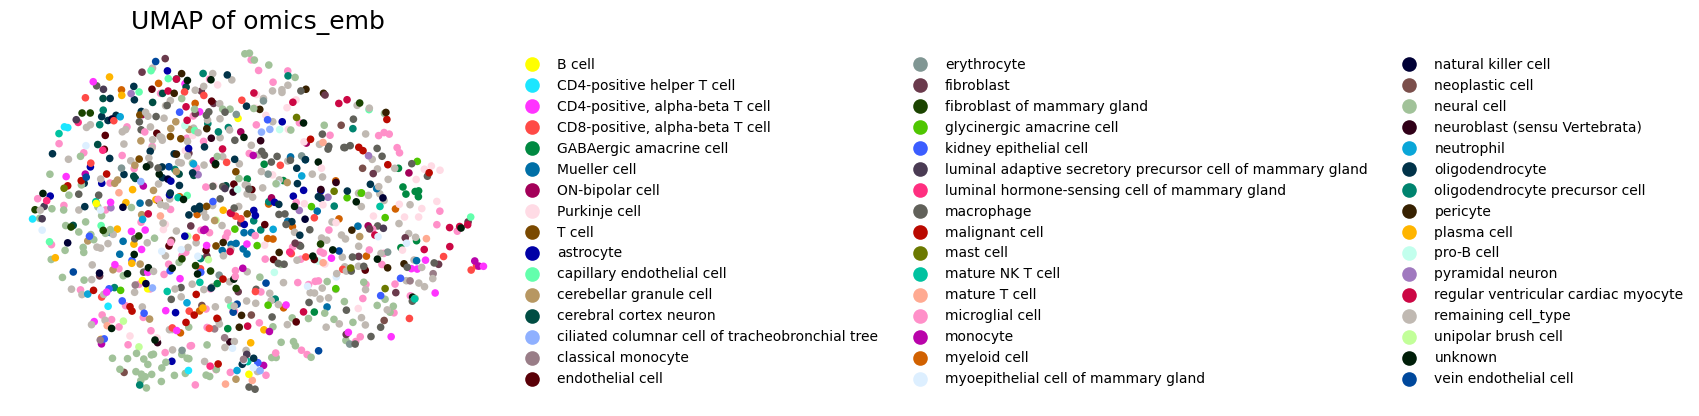

In [8]:
# Visualise the embeddings
from mmcontext.pl import plot_umap

plot_umap(adata_new, color_key="cell_type", embedding_key="omics_emb")

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='X_pp'.


<Figure size 800x800 with 0 Axes>

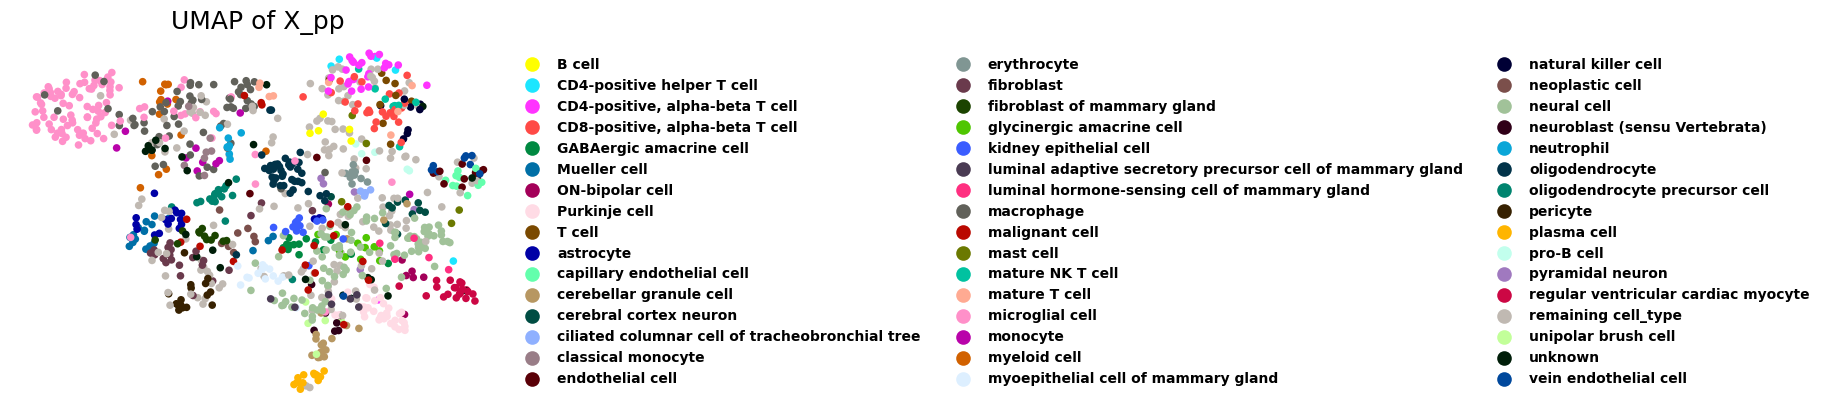

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [77]:
# Visualise the embeddings
from mmcontext.pl import plot_umap

plot_umap(adata_new, color_key="cell_type", embedding_key="X_pp")